<a href="https://colab.research.google.com/github/Jocelyn-git/DL/blob/main/FR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
#Hyperparameters (set values)
IMG_SIZE = 224
BS = 64

In [4]:
#Open the CSV file in reading mode and the TXT file in writing mode
with open('/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/ClassMap.csv', 'r') as f_in, open('/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/class_map.txt', 'w') as f_out:

    #Read the CSV file and store in variable
    content = f_in.read()

    #Write the content into the TXT file
    f_out.write(content)

In [5]:
with open('/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/class_map.txt','r+') as file:
    # read the lines
    lines = file.readlines()

    # delete the top line of the file
    file.seek(0)
    file.truncate()

    file.writelines(lines[1:])

with open('/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/class_map.txt','r') as file:
    lines = file.readlines()

for line in lines:
    print(line)

Jennie,0

Jisoo,1

Lisa,2

Rose,3

Others,4



In [6]:
with open('/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/class_map.txt') as f:
    lines = f.readlines()
liness = [l.strip().replace(" ", "") for l in lines]
CLASS_MAP = {pair.split(",")[0]: int(pair.split(",")[1]) for pair in lines}
NUM_CLASS = len(CLASS_MAP)

CLASS_MAP, NUM_CLASS

({'Jennie': 0, 'Jisoo': 1, 'Lisa': 2, 'Rose': 3, 'Others': 4}, 5)

In [7]:
#check format
liness

['Jennie,0', 'Jisoo,1', 'Lisa,2', 'Rose,3', 'Others,4']

In [7]:
# split train & valid
paths = glob('/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/Train/*/*.jpg')
train_paths, val_paths = train_test_split(paths, 
                                          test_size=0.3, 
                                          random_state=42)

len(train_paths), len(val_paths)

(403, 173)

((890, 736, 3),
 '/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/Train/Lisa/dgayeljlsm.jpg')

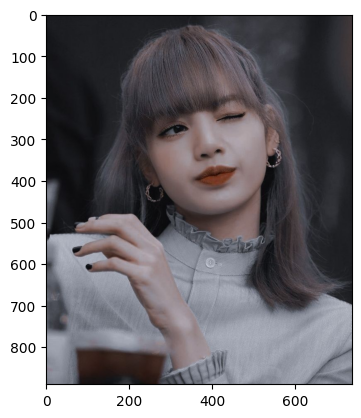

In [8]:
# visualization
path = np.random.choice(train_paths)
img = np.array(Image.open(path).convert("RGB"))
plt.imshow(img)
img.shape, path

In [9]:
# convert the file name to ids of class
# os.sep: "/"
def paths2labels(paths):
    return [CLASS_MAP[p.split(os.sep)[-2]] for p in paths]

In [ ]:
train_paths[:20], paths2labels(train_paths)[:20]

In [11]:
# loading images & resize
def load_and_resize_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

# 使用路徑建構 tf.data.Dataset
def build_ds(paths):
    labels = paths2labels(paths) # paths -> labels
    image_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_ds = image_ds.map(lambda path, label: (load_and_resize_image(path), label)) # path -> img, labels
    return image_ds

In [12]:
# 建構train, val dataset
train_ds = build_ds(train_paths).shuffle(buffer_size=len(train_paths)).batch(BS)
val_ds = build_ds(val_paths).batch(BS)

In [14]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
#Build Model
class WAIModel(tf.keras.models.Model):
    def __init__(self, encoder, preprocess, freeze):
        super().__init__()
        # 前處理函數
        self.preprocess = preprocess
        # 資料擴增
        self.data_aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
        ])
        # feature extractor
        self.encoder = encoder
        # classifier
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.activations.relu, #add
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(NUM_CLASS),
            tf.keras.layers.Softmax(),
        ])
        # freeze: 是否鎖住encoder參數
        if freeze:
            for l in self.encoder.layers:
                l.trainable = False
    def call(self, inputs, training=None):
        x = self.preprocess(inputs)
        # 非訓練時不使用資料擴增
        if training:
            x = self.data_aug(x)
            
        x = self.encoder(x, training)
        x = self.classifier(x, training)
        return x

Use pre-trained model. 

https://keras.io/api/applications/

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# 使用模型對應之前處理函式(revised)
'''
encoder = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, 
                                                            weights='imagenet')
'''
tf.keras.backend.clear_session()
preprocess = tf.keras.applications.efficientnet.preprocess_input
encoder = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, 
                                                            weights='imagenet')
for i, layer in enumerate(encoder.layers):
    print(i, layer.trainable, layer.name)

In [15]:
for layer in encoder.layers[:100]:
    layer.trainable = False

In [18]:
model = WAIModel(encoder = encoder, 
                 preprocess = preprocess,
                 freeze=True)

In [ ]:
model.encoder.summary()

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
model.fit(train_ds, 
          epochs=30, 
          validation_data=val_ds,
          callbacks=[
              tf.keras.callbacks.ModelCheckpoint("best.h5",
                                                 save_best_only=True,
                                                 save_weights_only=True)
          ])

In [20]:
# 讀取最佳val_loss model參數
model.load_weights("best.h5")

In [21]:
def load_and_resize_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

In [22]:
# 建構test dataset
test_paths = glob('/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/Test/*.jpg')
test_ds = tf.data.Dataset.from_tensor_slices((test_paths))
test_ds = test_ds.map(lambda path: load_and_resize_image(path)).batch(BS)

In [ ]:
test_paths

In [24]:
#create filename from test files
filename_tmp = []
# input file path 
inputfilepath = test_paths
# split path
for i in inputfilepath:
  filepath = os.path.basename(i)
  filepath_tmp0 = filepath.split("Test")
  filepath_tmp1 = filepath_tmp0[0].split(".")
  filename_tmp.append(filepath_tmp1[0])
print(filename_tmp)

filename= pd.DataFrame(filename_tmp)
filename

['aicvqlzywv', 'afamswrgzu', 'acltakyuqj', 'ajmuodfgaa', 'ahirrziqwj', 'afzztlycia', 'akemkgggla', 'akwqggjjvl', 'adzfjfazdu', 'afnbnsgqgg', 'adtkdayqxa', 'abzrmwclir', 'cnidtksnzg', 'csluownxac', 'aockyptjtp', 'cklaomjvmn', 'ckcxglkyib', 'cfeqzmgqqg', 'atuunxhefv', 'ckokyhbevp', 'cgmkdaxpum', 'cgrzaxiwmr', 'cdcgtcirrc', 'bfnzgwohut', 'cptfxirdnq', 'atqxkxkmcu', 'apnnaorvek', 'cmanmhvoio', 'bggohsqcqj', 'bcwnezvhww', 'atcdygunti', 'avzqztsllp', 'buxbmpiwmh', 'bmkxhblqvp', 'ckwoagzuss', 'bqmjfuiyvh', 'alwrlcjegi', 'chapbyegje', 'bgkcklpkwz', 'brphcknuqu', 'cpcfmmgeni', 'axligmmvlk', 'brhnkwnqmr', 'anxxktsobi', 'asznazhesu', 'cmnhupznha', 'ceoilwjtwo', 'alfnpdadvl', 'autfromwgd', 'ayimxaylld', 'bhfllqnjfq', 'bcdeovpfsy', 'cuzldwvhfv', 'bkbjflychq', 'bfiwanhndq', 'awhuoryxys', 'avftecfswg', 'bmneysnvik', 'crdclxlkzl', 'cgcfhgpqwx', 'cpzfbimrgi', 'cesdadsbje', 'bapyjsosbo', 'cnvvmicfwh', 'apvlbradzl', 'avxdthawqo', 'avypmcxcwr', 'bgunfdvkcm', 'bzyxuybwxb', 'gwxquxvrze', 'fjxgoaavtf', 'dqyz

,0
0,aicvqlzywv
1,afamswrgzu
2,acltakyuqj
3,ajmuodfgaa
4,ahirrziqwj
...,...
572,zjondcjihp
573,zhgwwxnork
574,zqwimwspix
575,zpnavnfpzn


In [25]:
#predict
prediction = model.predict(test_ds)
prediction = np.argmax(prediction, axis=-1)

10/10 [==============================] - 6s 402ms/step


In [30]:
#create submission file
df = pd.read_csv('/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/SampleSubmission.csv')
df.head()
df["filename"]= filename
df["label"] = prediction
df.to_csv("/content/drive/MyDrive/AIA Colab/Mid-Exam/face-recognition/submission.csv", index=None)